# Visualizing antibody embeddings

In this walkthrough we will visualize embeddings from antibodies all derived from a common parent. In doing so we will show that that such proteins have a characteristic star-burst based pattern that derives from their relation to a common parent. 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.special
import json

## Connect to the OpenProtein.AI API

In [2]:
import openprotein

with open('secrets.config', 'r') as f:
    config = json.load(f)

session = openprotein.connect(config['username'], config['password'])

## Basic inference endpoints

Models in the embedding module can be selected with the `session.embedding.get_model(model_id)` function and expose three basic inference methods

* `model.embed([sequences], reduction='MEAN')` - request embeddings, returning the mean embedding over the sequence length by default. reduction='SUM' and reduction=None are also options, which return the summed embedding or the full LxD sized embedding (a D-dimensional embedding for each position of the sequence)
* `model.logits([sequences])` - request logits, returning the final output layer of the language model
* `model.attn([sequences])` - request attention maps, returning the attention maps for the final layer of transformer models. these are HxLxL where H is the number of attention heads used by the model
* `model.fit_svd([sequences], n_components=1024, reduction=None)` - fit a SVD decomposition of the embeddings of the input sequences, truncated to the specified number of components after applying the specified embedding reduction. Using `reduction=None` requires the sequences to all be the same length. The resulting SVD model is especially useful for retrieving high fidelity, custom-sized embeddings of large numbers of sequences or sequence variants, because full sized embeddings are large and can be cumbersome to download and work with. This will be covered in more detail later in the walkthrough.

Sequences are expected to be amino acid sequences using the standard single character amino acid alphabet, plus `X` to indicate masked/unknown positions. More information about can be retrieved from the model metadata (`model.metadata`) which includes sequence length constraints and other information. Available models can be listed with `session.embedding.list_models()`.

_Note_ - ESM models will return length plus 2 ($L+2$) rather than $L$ sized results for full embeddings, logits, and attn, because "\<start\>" and "\<stop\>" tokens are appended to the input sequences.

In [3]:
# let's work with an antibody heavy chain sequence and our rotaprot-large-uniref90-ft model
wt = b'EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS'
model = session.embedding.get_model('rotaprot-large-uniref90-ft')
print(model)

rotaprot-large-uniref90-ft


## Inference requests are asynchronous
Inference functions return asynchronous `Future` objects that can be queried for job completion status, waited on, and used to retrieve results once available. The `Future` wraps a `Job` object including a `job_id` and other information about the job that can be used to re-connect and retrive results later.

## Logits are un-normalized log-probabilities of amino acids at each position according to the masked-LM

In [4]:
logits_future = model.logits([wt])
print(logits_future.job)

# wait until the results are ready, polling periodically and reporting job progress (if multiple sequences are sent in the inference request)
logits_future.wait_until_done(verbose=True)

# get the results, this is a list of (sequence, np.ndarray) tuples
# these are not guaranteed to be in the same order as the input, so it's generally recommended to check the sequence in the returned results
logits_results = logits_future.get()
returned_sequence, logits = logits_results[0]
print(returned_sequence)
# logits are of shape LxV, where V is the vocabulary size for the model (20 in this case)
# logits are not softmaxed, so if normalized probabilities are required they should be passed through a softmax or log_softmax function
print(logits.shape)

num_records=1 job_id='f41e658a-c30e-4b20-83c6-d61df13c543e' job_type=<JobType.embeddings_logits: '/embeddings/logits'> status=<JobStatus.SUCCESS: 'SUCCESS'> created_date=datetime.datetime(2024, 10, 15, 16, 28, 4, 845763, tzinfo=TzInfo(UTC)) start_date=datetime.datetime(2024, 10, 15, 16, 28, 4, 876104, tzinfo=TzInfo(UTC)) end_date=datetime.datetime(2024, 10, 15, 16, 28, 4, 876106, tzinfo=TzInfo(UTC)) prerequisite_job_id=None progress_message=None progress_counter=100 sequence_length=None


Waiting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 380.39it/s, status=SUCCESS]


b'EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS'
(118, 20)


Let's plot these logits by position:

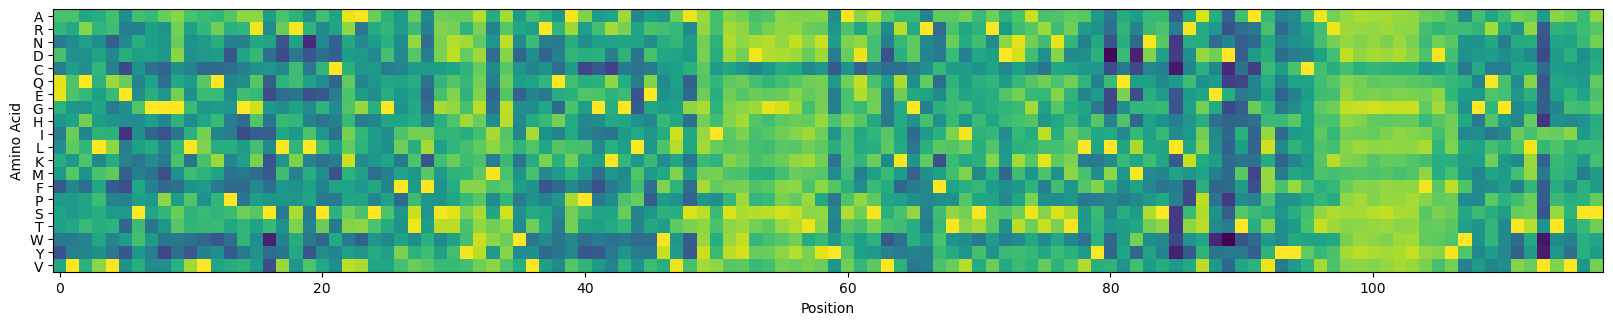

In [5]:
# plot the logits
alphabet = model.metadata.output_tokens

_, ax = plt.subplots(figsize=(20, 4))
ax.imshow(scipy.special.log_softmax(logits, axis=-1).T)
_ = ax.set_xlabel('Position')
_ = ax.set_ylabel('Amino Acid')
_ = ax.set_yticks(np.arange(len(alphabet)), alphabet)

## Embeddings and reduced embeddings

Embeddings for a sequence are LxD, where L is the length of the sequence and D is the embedding dimension of the model. This can be prohibitively large for many sequences, as D is generally 1024 or larger. Reduced embeddings are of shape D and are either the mean (`reduction='MEAN'`) or the sum (`reduction='SUM'`) of the embeddings over the length dimension of the sequence.

Full size embeddings (`reduction=None`) generally give better fidelity, but mean embeddings are still powerful features and are easier to manipulate as we can make them uniform across proteins of different sequence lengths. In general, the reduced embeddings perform only marginally worse than full-sized embeddings in explaining protein sequences, but we leave it up to the user to decide what is most appropriate. 


In [6]:
# because requests are async, these will run in parallel without waiting 
embedding_full_future = model.embed([wt], reduction=None)
print('FULL', embedding_full_future.job)
embedding_mean_future = model.embed([wt], reduction='MEAN') # mean is the default
print('MEAN', embedding_mean_future.job)
embedding_sum_future = model.embed([wt], reduction='SUM') # we provide SUM as an option, but MEAN is generally the better reduction
print('SUM', embedding_sum_future.job)

# wait on the results
fs = [embedding_full_future, embedding_mean_future, embedding_sum_future]
for f in fs:
    f.wait_until_done(verbose=True)

# NOTE - for large numbers of full size embeddings, downloading them can actually be the slowest step
result_full = embedding_full_future.get()
print('FULL shape =', result_full[0][1].shape)

result_mean = embedding_mean_future.get()
print('MEAN shape =', result_mean[0][1].shape)

result_sum = embedding_sum_future.get()
print('SUM shape =', result_sum[0][1].shape)

FULL num_records=1 job_id='50d3fe30-1dc0-4df1-bd58-485e40789e32' job_type=<JobType.embeddings_embed: '/embeddings/embed'> status=<JobStatus.SUCCESS: 'SUCCESS'> created_date=datetime.datetime(2024, 10, 15, 16, 28, 5, 913798, tzinfo=TzInfo(UTC)) start_date=datetime.datetime(2024, 10, 15, 16, 28, 5, 953228, tzinfo=TzInfo(UTC)) end_date=datetime.datetime(2024, 10, 15, 16, 28, 5, 953230, tzinfo=TzInfo(UTC)) prerequisite_job_id=None progress_message=None progress_counter=100 sequence_length=None
MEAN num_records=1 job_id='67caa067-3517-4a40-aa0c-9c8c5d84643a' job_type=<JobType.embeddings_embed: '/embeddings/embed'> status=<JobStatus.SUCCESS: 'SUCCESS'> created_date=datetime.datetime(2024, 10, 15, 16, 28, 6, 266660, tzinfo=TzInfo(UTC)) start_date=datetime.datetime(2024, 10, 15, 16, 28, 6, 294611, tzinfo=TzInfo(UTC)) end_date=datetime.datetime(2024, 10, 15, 16, 28, 6, 294613, tzinfo=TzInfo(UTC)) prerequisite_job_id=None progress_message=None progress_counter=100 sequence_length=None
SUM num_re

Waiting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 387.73it/s, status=SUCCESS]


FULL shape = (118, 1536)
MEAN shape = (1536,)
SUM shape = (1536,)


In [7]:
print(result_mean)

[(b'EVQLVETGGGLVQPGGSLRLSCAASGFTLNSYGISWVRQAPGKGPEWVSVIYSDGRRTFYGDSVKGRFTISRDTSTNTVYLQMNSLRVEDTAVYYCAKGRAAGTFDSWGQGTLVTVSS', array([ 2.0975683 , -0.31056938, -0.8668751 , ..., -0.10007567,
       -0.08768166, -0.95555604], dtype=float32))]


## Attention maps can reveal statistical couplings between sites 

In [8]:
attn_future = model.attn([wt])
print(attn_future.job)

attn_future.wait_until_done(verbose=True)

attn_result = attn_future.get()
attn_map = attn_result[0][1]
attn_map.shape

num_records=1 job_id='91ffa02c-a933-45fa-8e92-49c5be7928f2' job_type=<JobType.embeddings_attn: '/embeddings/attn'> status=<JobStatus.SUCCESS: 'SUCCESS'> created_date=datetime.datetime(2024, 10, 15, 16, 28, 9, 661764, tzinfo=TzInfo(UTC)) start_date=datetime.datetime(2024, 10, 15, 16, 28, 9, 696815, tzinfo=TzInfo(UTC)) end_date=datetime.datetime(2024, 10, 15, 16, 28, 9, 696816, tzinfo=TzInfo(UTC)) prerequisite_job_id=None progress_message=None progress_counter=100 sequence_length=None


Waiting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 396.17it/s, status=SUCCESS]


(24, 118, 118)

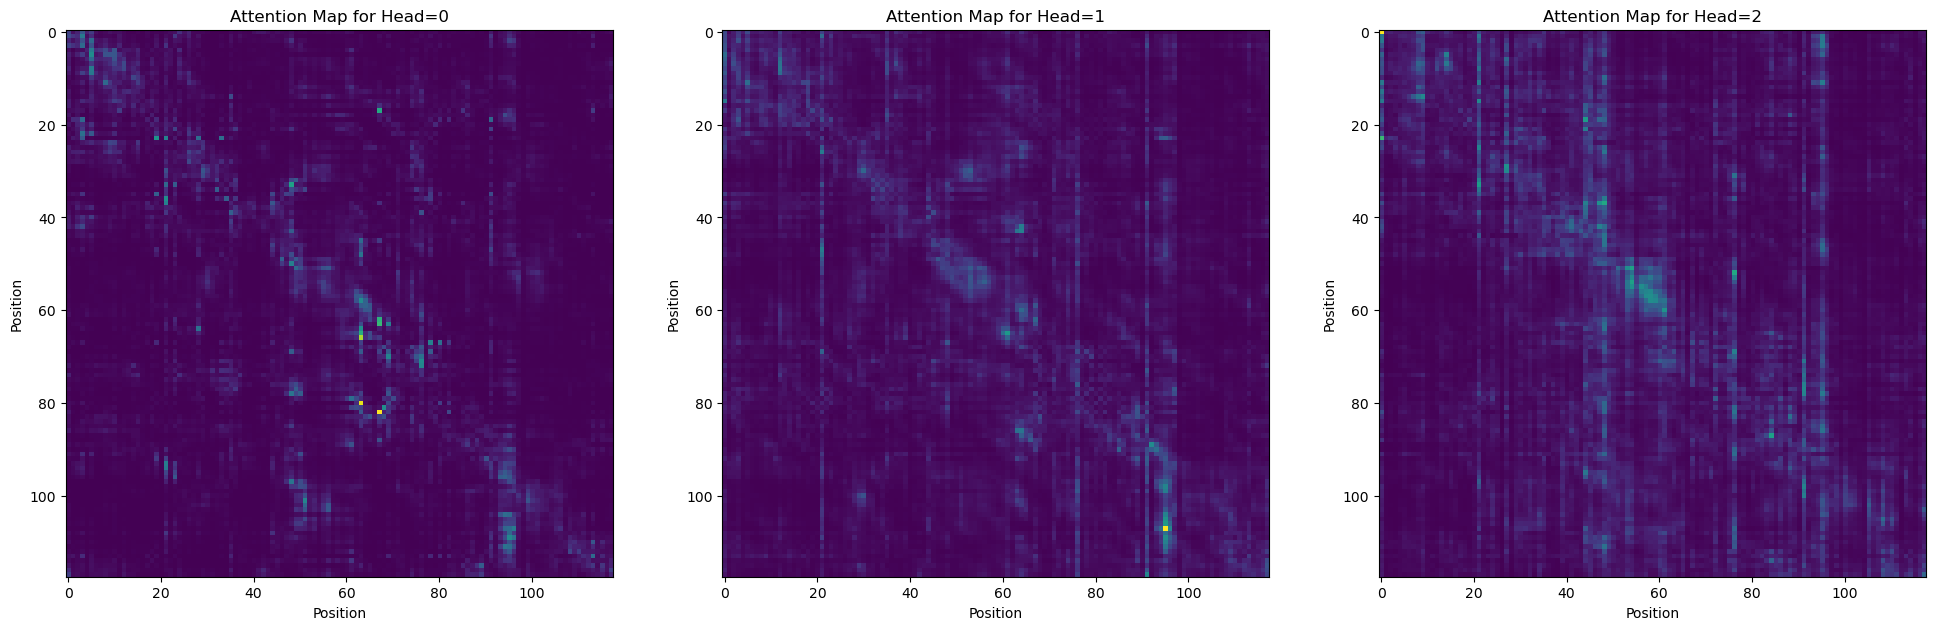

In [9]:
# plot a few attention heads
_, axs = plt.subplots(1, 3, figsize=(24, 8))
for i in range(len(axs)):
    axs[i].imshow(attn_map[i])
    _ = axs[i].set_title(f'Attention Map for Head={i}')
    _ = axs[i].set_xlabel('Position')
    _ = axs[i].set_ylabel('Position')

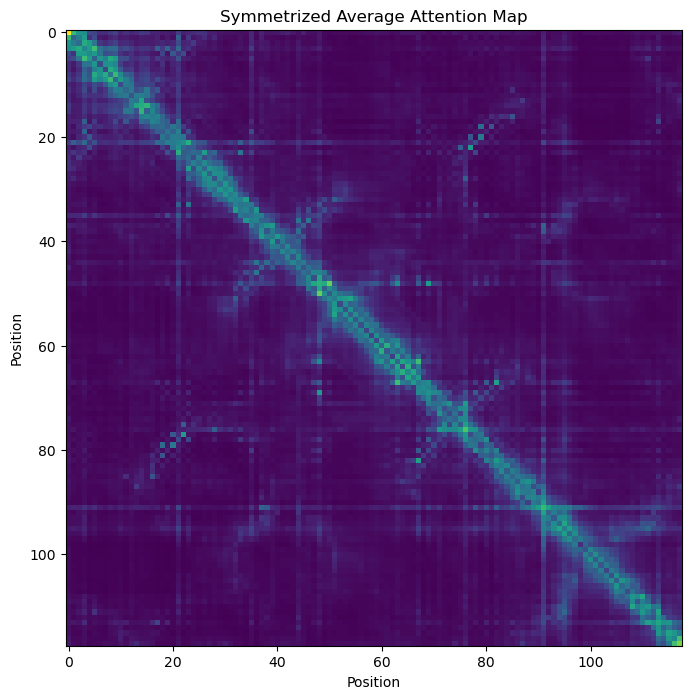

In [10]:
# plot the symetrized average attention map
a = attn_map.mean(axis=0)
a = a + a.T - a*a.T

_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(a)
_ = ax.set_title('Symmetrized Average Attention Map')
_ = ax.set_xlabel('Position')
_ = ax.set_ylabel('Position')

## Using SVD to get high-fidelity custom-sized embeddings

Truncated SVD can be used to find reduced sized protein embeddings that retain the most information by finding vectors that best explain the localized sequence space. 

This is extremely useful for retrieving large numbers of embeddings for mutagenesis analysis. The SVD can be fit on any set of sequences using the `model.fit_svd()` function, but these sequences must be of equal length if `reduction=None` (the default) is used. This returns a new SVD model object that can be used to embed new sequences.

Existing SVD models can be listed and retrieved with `session.embedding.list_svd()` and can be deleted with the `svd.delete()` function.

In [11]:
# enumerate all single substution variants of the seed sequence and use those to fit an SVD'd embedding of the local sequence landscape
alphabet = model.metadata.output_tokens
alphabet = [c.encode() for c in alphabet] # encode to bytes since we're working with byte strings

variants = [wt]
for i in range(len(wt)):
    wt_i = wt[i:i+1]
    for j in range(len(alphabet)):
        if alphabet[j] != wt_i:
            v = wt[:i] + alphabet[j] + wt[i+1:]
            assert len(v) == len(wt)
            assert v != wt
            variants.append(v)
print(len(variants))

# fit a small SVD
svd = model.fit_svd(variants, n_components=256)
print(svd.metadata.model_dump_json(indent=4))
svd.wait_until_done(verbose=True)

2243
{
    "id": "8bd030dc-c4b4-4aba-b0a4-f4b847a49e99",
    "status": "PENDING",
    "created_date": "2024-10-15T16:28:11.749022Z",
    "model_id": "rotaprot-large-uniref90-ft",
    "n_components": 256,
    "reduction": null,
    "sequence_length": 118
}


Waiting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.11it/s, status=SUCCESS]


True

In [12]:
# embed the variants
# NOTE - you need to wait for the embedding model to finish fitting before calling embed
# otherwise you will get an error

svd_embed_future = svd.embed(variants)
print(svd_embed_future.job)
svd_embed_future.wait_until_done(verbose=True)

svd_embed_results = svd_embed_future.get()
len(svd_embed_results)

num_records=2243 job_id='ec58ee9c-8b4b-4fce-94d3-2f6e1b198369' job_type=<JobType.svd_embed: '/svd/embed'> status=<JobStatus.PENDING: 'PENDING'> created_date=datetime.datetime(2024, 10, 15, 16, 28, 18, 448735, tzinfo=TzInfo(UTC)) start_date=None end_date=None prerequisite_job_id=None progress_message=None progress_counter=0 sequence_length=None


Waiting: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.17it/s, status=SUCCESS]


2243

In [13]:
embedding_vectors = np.stack([v for _,v in svd_embed_results], axis=0)
embedding_vectors.shape

(2243, 256)

In [14]:
# visualize a UMAP of these embeddings
from umap import UMAP

um = UMAP(n_components=2, n_neighbors=30, min_dist=0)
z = um.fit_transform(embedding_vectors)

/Users/jmage/.micromamba/envs/openprotein-sdk/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


the UMAP (below) shows a characteristic star burst pattern typical of single substitions of a parent sequence

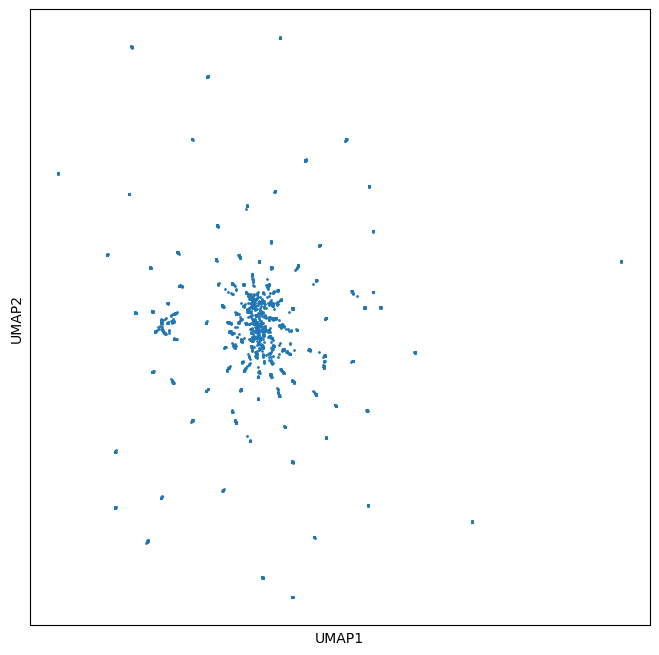

In [15]:
_, ax = plt.subplots(figsize=(8, 8))
ax.scatter(z[:, 0], z[:, 1], s=1)
_ = ax.set_xticks([], [])
_ = ax.set_yticks([], [])
_ = ax.set_xlabel('UMAP1')
_ = ax.set_ylabel('UMAP2')